[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sapiosciences/sapio-py-tutorials/blob/master/1_query_data_records.ipynb)

# Create Connection

For each notebook, we always start with creation of a *SapioUser* object.

The *SapioUser* object describes the connection endpoint, and the api user authentication information.

# Dedicated Hosting
## Standard API Users
A dedicated, standard api-user object will require the following fields to be filled, at minimum:


*   url: The URL to the webservice.war tomcat deployment in the embedded tomcat of Sapio platform.
*   guid: The guid of the Sapio app you are connecting. There can be more than one app running on each Sapio BLS (DataMgmtServer). This will provide disambiguity to your credentials. You can find this information in Sapio Informatics Portal.
*   username: The username of the api user.
*   password: The password of the api user.

Sapio platform allows you to use the same API credential to connect concurrently, each concurrent connection will consume one concurrent connection seat.


To find the account/portal information, navigate to sapio portal and check the relevant app. In this example, my app guid is "3c232543-f407-4828-aae5-b33d4cd31fa7"

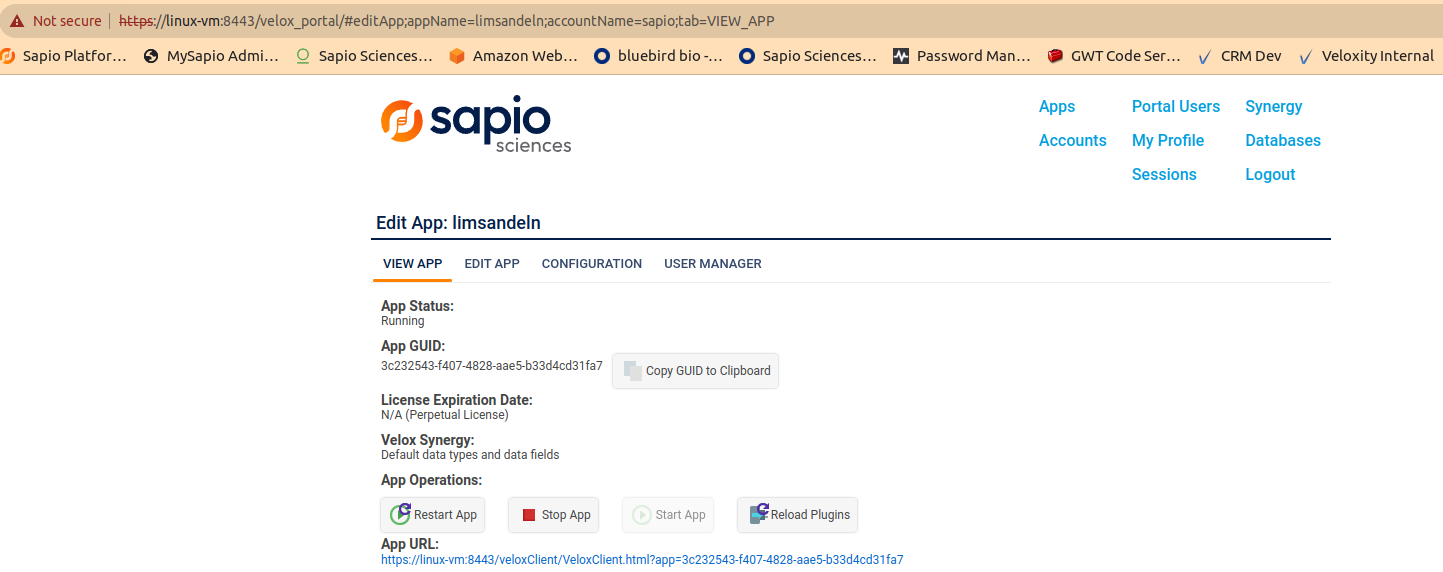

## Webservice API Users
These users are created in Configuration Manager => WebService API Key.

**The previous key is deleted and becomes invalid each time you re-generate. You will not be able to view this key after you finish generation, but you can reset-and-invalidate anytime.**

API users created this way will require the following attributes in SapioUser object:



*   url: The URL to the webservice.war tomcat deployment in the embedded tomcat of Sapio platform.
*   guid: The guid of the Sapio app you are connecting. There can be more than one app running on each Sapio BLS (DataMgmtServer). This will provide disambiguity to your credentials. You can find this information in Sapio Informatics Portal.
*   api_token: The key written to you when you click "*Request New Web Service API Key*" button.

# SaaS Customers
For SapioUser objects connecting to SaaS infrastructure (Bronze/Silver/Gold hosting solutions), the following parameters should be filled for SapioUser object:


*   url: The URL of your Sapio app website, followed by 'webservice/api'. For example: https://customer_name.exemplareln.dev/webservice/api or https://customer_name.exemplareln.com/webservice/api
*   api_token: The key written to you when you click "*Request New Web Service API Key*" button.
*   Leave the "guid" as "None". You do not need to fill this if you have a SaaS URL like so. Sapio will automatically map your URL to guid.

**This may not work if you are using Sapio Platnium SaaS hosting with old SAML/SSO configs, or older hosting AMI. Refer to Dedicated Hosting SapioUser settings instead.**


In [ ]:
from sapiopylib.rest.User import SapioUser
from sapiopylib.rest.DataRecordManagerService import DataRecord
from sapiopylib.rest.DataRecordManagerService import DataRecordPojoPageCriteria
from sapiopylib.rest.DataMgmtService import DataMgmtServer
from sapiopylib.rest.DataRecordManagerService import DataRecordPojoHierarchyPageCriteria

user = SapioUser(url="https://linux-vm:8443/webservice/api",
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7", account_name="sapio",
                 username="pyRestTest", password="Password1!", verify_ssl_cert=False)
dataRecordManager = DataMgmtServer.get_data_record_manager(user)

We just created a new connection! In this case, we are not using api-token but rather we are specifying the guid, username, password instead.

These commands do not produce any results yet.

Now let's try to query for record ID = 1

We set Verify SSL to false because it's a SELF SIGNED CERT. In production, you want to keep this flag to true, and have real SSL certificate for Sapio Platform.

# Query Data Records

In [ ]:
result = dataRecordManager.query_data_records_by_id("Directory", [1])
if len(result.result_list) > 0:
    result_list: list = result.result_list
    element: DataRecord = result_list[0]
    print(element.get_record_id())
    print(element.get_fields())

In example above, we query a directory whose record ID is 1 (which by the way is the root directory. We print the record ID and the fields of the record.
Alternatively, you can direct print a DataRecordPojo object or a page's result directly. It will show the data record name of these data records.


In [ ]:
result = dataRecordManager.query_data_records("Sample", "SampleId", ["000007"])
print(result)

Paging is available. In the next example we are going to get samples, 10 samples per page for 3 pages.

In [ ]:
next_page = DataRecordPojoPageCriteria(page_size=10)
for i in range(3):
    result = dataRecordManager.query_all_records_of_type("Sample", next_page)
    next_page = result.next_page_criteria
    print("Page " + str(i + 1) + ": " + str(result))
    if not result.is_next_page_available:
        break

query_system_for_record returns either the DataRecordPojo when it finds a record, or a "None" object if it's not found.

In [ ]:
result = dataRecordManager.query_system_for_record('Directory', 1)
print(result)
result = dataRecordManager.query_system_for_record('Directory', 1000000)
print(result)

You can get parents and children of the records.
The easiest form is to take a single record and get children of that.

In this example, we find one FCS file and try to get its parent sample.

In [ ]:
fcs_result = dataRecordManager.query_all_records_of_type("FCSFile", DataRecordPojoPageCriteria(page_size=1))
if len(fcs_result.result_list) > 0:
    fcs_record = fcs_result.result_list[0]
    parents = dataRecordManager.get_parents(fcs_record.get_record_id(), "FCSFile", "Sample")
    if len(parents.result_list) > 0:
        parent_sample = parents.result_list[0]
        print(parent_sample)

In a slightly more complex case, we will be using a batch call to retrieve parents of multiple FCS children at once.

It is often much faster to use batch call than calling records in a loop. This will reduce the HTTP and remote overhead.

The result object is slightly different. To demonstrate paging in this situation, we will try to have a page of 10 on parents, for first five pages of parents for first 100 FCS records.
Note: Since each FCS record has a parent, this will not complete the entire query. The remaining pages will simply never be computed nor returned here.

In [ ]:
fcs_result = dataRecordManager.query_all_records_of_type("FCSFile", DataRecordPojoPageCriteria(page_size=100))
samples = list()
if len(fcs_result.result_list) > 0:
    fcs_record_id_list = [x.get_record_id() for x in fcs_result.result_list]
    fcs_record_by_record_id = dict((x.get_record_id(), x) for x in fcs_result.result_list)
    next_parent_page_criteria = DataRecordPojoHierarchyPageCriteria(page_size=10)
    for i in range(5):
        print("Page " + str(i + 1))
        parents = dataRecordManager.get_parents_list(fcs_record_id_list, "FCSFile", "Sample", next_parent_page_criteria)
        next_parent_page_criteria = parents.next_page_criteria
        for source_record_id, result_records in parents.result_map.items():
            if result_records is None or len(result_records) == 0:
                continue
            fcs_record = fcs_record_by_record_id.get(source_record_id)
            samples.extend(result_records)
            if fcs_record is not None:
                print(str(fcs_record) + " -> [" + ', '.join([str(x) for x in result_records]) + "]")
        if not parents.is_next_page_available:
            break

You can translate data in a list of data records into a pandas data frame, which can be used by external tools!

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100)
samples_data_frame = dataRecordManager.get_data_frame(samples)
display(samples_data_frame)

# Auto-Paging

Recall in the previous sections of the tutorial we had a paging loop like this:


```
next_page = DataRecordPojoPageCriteria(page_size=10)
for i in range(3):
    result = dataRecordManager.query_all_records_of_type("Sample", next_page)
    next_page = result.next_page_criteria
    print("Page " + str(i + 1) + ": " + str(result))
    if not result.is_next_page_available:
        break
```

You may have to page through the records in the smiliar fashion all time time. You may not really be concerned about which page it is in, but rather just be able to get all records (or all records up to a limit determined by you).

In this case, using our auto-paging API can save quite a bit of work:


In [ ]:
from sapiopylib.rest.utils.autopaging import *
pager = QueryAllRecordsOfTypeAutoPager("Directory", user, DataRecordPojoPageCriteria(page_size=10))
for record in pager:
  print(str(record))

In the example above, we see that all auto-paging classes from sapiopylib can be imported through sapiopylib.rest.utils.autopaging module.
We also see that each auto-pager class impleents its own iterator. Each auto-pager acts as one-time iterator by itself (with no ability of going backward. If you want to revisit elements, you may need to store records you have obtained in another containre such as List or a file)

It is also possible to obtain all results in a single call. For classes such as QueryAllRecordsOfTypeAutoPager it may be easy to understand the differences between iterating in a loop and obtaining all results at once. All we would have been doing is basically collecting them results into a single list.
So the code above would have the following effect as the code below

In [ ]:
pager = QueryAllRecordsOfTypeAutoPager("Directory", user, DataRecordPojoPageCriteria(page_size=3))
all_records: List[DataRecord] = pager.get_all_at_once()
for record in all_records:
  print(str(record))

In other pagers such as hierarchal pagers and side link pagers, there are subtle differences between the two ways you may have to remember.

Consider the following code

In [ ]:
children_pager = GetChildrenListAutoPager([x.record_id for x in all_records], "Directory",
                                                  user, DataRecordPojoHierarchyPageCriteria(page_size=3))

The children_pager variable is also an iterator. But this time, it is not an iterator of data records. Rather it is a **partial** dictionary of (record ID) -> children records (of data type "Directory", in this case)
What does that mean for it to be a partial dictionary? It means that:


1.   Each occurance of the record ID key does not completely visit all of its children.
2.   The entire children list for each record ID of provided record ids is equal to the union of all results keyed by the same record ID.

This signature is the same signature that is returend by dataRecordManager and that of the Sapio REST APi specfication. A partial result can be returned in such as case where if any of the record has x number of children, where x does not divide the page size (with no remainders).


Therefore, in order to properly collect the all record IDs for all provided records, we must combine the union of all such sets of results:

In [ ]:
all_results: SetMultimap[int, DataRecord] = SetMultimap()
for parent_record_id, children_records_partial in children_pager:
  all_results.put_all(parent_record_id, children_records_partial)

It would be **incorrect** if we were to replace the key in dictionary for each parent_record_id, as that would eliminate the partial results entered in the earlier page.

However, you can save all those work collecting the partial results, if you use the other method to obtain all records at once. Assuming the entire result can fit into the heap of your code memory.

Therefore, the code above is equilveant to:

In [ ]:
all_results: SetMultimap[int, DataRecord] = children_pager.get_all_at_once()

Note that if you are trying to use record model then implicitly it would already mean you made the decision to fit all pages into one heap of the memory.